In [101]:
import os
import sys
import time
import numpy as np 
import pandas as pd
import gc
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import json
import pickle
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from rouge import Rouge
from nltk import sent_tokenize
import torch.nn.functional as F

import math
import os
import random
import string

# Pytorch library for training
import torch
from torch import optim

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [78]:
%%time
data = pd.read_csv('wikihowSep.csv')
data = data[:100000]
data = data.astype(str)
rows, columns = data.shape

CPU times: user 8.96 s, sys: 785 ms, total: 9.74 s
Wall time: 9.83 s


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
contraction_map={
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd've": "how did have",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "shall'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "will't've": "will not have",
    "would've": "would have",
    "would't": "would not",
    "would't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you have all",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

def expand_contractions(sent, mapping):
    #pattern for matching contraction with their expansions
    pattern = re.compile('({})'.format('|'.join(mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    
    def expand_map(contraction):
        #using group method to access subgroups of the match
        match = contraction.group(0)
        #to retain correct case of the word
        first_char = match[0]
        #find out the expansion
        expansion = mapping.get(match) if mapping.get(match) else mapping.get(match.lower())
        expansion = first_char + expansion[1:]
        return expansion
    #using sub method to replace all contractions with their expansions for a sentence
    #function expand_map will be called for every non overlapping occurence of the pattern
    expand_sent = pattern.sub(expand_map, sent)
    return expand_sent

In [82]:
data['num_word'] = data['text'].apply(lambda x: len(str(x).split()))
num_word = np.sort(data['num_word'].values)

data['num_word_hl'] = data['headline'].apply(lambda x: len(str(x).split()))
num_word_hl = np.sort(data['num_word_hl'].values)

min_text_len = num_word[int(len(num_word)*0.1)]
max_text_len = num_word[int(len(num_word)*0.95)]

min_hl_len = num_word_hl[int(len(num_word_hl)*0.1)]

In [83]:
headline_ratio_threshold = 0.75

del_idx = []
for i in range(rows):
#     if data['num_word'][i] < max_text_len and data['num_word'][i] > min_text_len:
    if data['num_word'][i] < min_text_len:
        del_idx.append(i)
    else:
        pass
    
    if max_text_len < data['num_word'][i]:
        del_idx.append(i)
    else:
        pass

    if data['num_word_hl'][i] > headline_ratio_threshold*data['num_word'][i]:
        del_idx.append(i)
    else:
        pass
    
    if data['num_word_hl'][i] < min_hl_len:
        del_idx.append(i)
    else:
        pass

In [84]:
data_new = data.drop(del_idx)
del data

In [85]:
data_new.shape

(77774, 7)

In [86]:
def data_loader(dataframe, target_col): 
    # Extraction from dataframe into a list
    text = [article for article in getattr(dataframe, target_col)]
    
    # Removing accented characters
    text = [unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') for sentence in text]
    
    # Expanding contractions
    text = [expand_contractions(sentence, contraction_map) for sentence in text]

    # Removing special characters
    pat1 = r'[^a-zA-z0-9.,!?\s]' 
    # pat1 = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = [re.sub(pat1, '', sentence) for sentence in text]
    
    # Removing extra commas
    pat2 = r'[.]+[\n]+[,]'
    text = [re.sub(pat2,".\n", sentence) for sentence in text]
    
    # Removing extra whitespaces and tabs
    # pat3 = r'^\s*|\s\s*'
    pat3 = r'^\s+$|\s+$'
    text = [re.sub(pat3, '', sentence).strip() for sentence in text]
    
    # Add space before '.'
    pat4 = r'\.|\?|\！|\,'
    text = [re.sub(pat4, ' ', sentence) for sentence in text]
    
    # Lowercase
    text = [sentence.lower() for sentence in text]
    
    # Tokenize
    text = [('sos ' + sentence + ' eos').split() for sentence in text]
    
    return np.array(text, dtype=object)

In [89]:
%%time
text_data = data_loader(data_new, 'text')
headline_data = data_loader(data_new, 'headline')

CPU times: user 50.4 s, sys: 343 ms, total: 50.7 s
Wall time: 51 s


In [90]:
text_data.shape, headline_data.shape

((77774,), (77774,))

In [91]:
text_train, text_test, headline_train, headline_test = train_test_split(text_data, headline_data, test_size=0.1, random_state=1)
text_train, text_dev, headline_train, headline_dev = train_test_split(text_train, headline_train, test_size=0.1, random_state=1)

In [92]:
del text_data, headline_data

In [93]:
text_train.shape

(62996,)

In [94]:
def data_sorter(text, headline): 
    headline = [y for x,y in sorted(zip(text, headline), key = lambda pair: len(pair[0]), reverse = True)]
    text = list(text)
    text.sort(key = lambda x: len(x), reverse = True)

    return np.array(text), np.array(headline)

In [95]:
text_train, headline_train = data_sorter(text_train, headline_train)
text_test,  headline_test  = data_sorter(text_test, headline_test)
text_dev,   headline_dev   = data_sorter(text_dev, headline_dev)

In [96]:
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token
    UNK_token = 3   # Out-of-vocabulary token

    def __init__(self, name):
        self.name = name
        self.word2index = {"pad":0, "sos":1, "eos":2, "unk":3}
        self.word2count = {"pad":0, "sos":0, "eos":0, "unk":0}              
        self.index2word = {0: "pad", 1: "sos", 2: "eos", 3: "unk"}
        self.num_words = 4
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence:           
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            self.longest_sentence = sentence_len
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [97]:
text_vocabulary = Vocabulary('text')
headline_vocabulary = Vocabulary('headline')

In [98]:
#text
for i in range(len(text_train)):
    text_vocabulary.add_sentence(text_train[i])
    for word in text_train[i]:
        text_vocabulary.add_word(word)
for i in range(len(text_dev)):
    text_vocabulary.add_sentence(text_dev[i])
    for word in text_dev[i]:
        text_vocabulary.add_word(word)
#headline
for i in range(len(headline_train)):
    headline_vocabulary.add_sentence(headline_train[i])
    for word in headline_train[i]:
        headline_vocabulary.add_word(word)
for i in range(len(headline_dev)):
    headline_vocabulary.add_sentence(headline_dev[i])
    for word in headline_dev[i]:
        headline_vocabulary.add_word(word)

In [99]:
print(len(text_vocabulary.word2index.keys()))
print(len(headline_vocabulary.word2index.keys()))

57237
18431


In [21]:
def w2in(data,vocabulary):
    data_idx = []
    lengths = []
    for i in range(len(data)):
        idx = []
        lengths.append(len(data[i]))
        for word in data[i]:
            try:
                word2index = vocabulary.to_index(word)
            except:
                word2index = vocabulary.to_index('unk')
            idx.append(word2index)
        data_idx.append(torch.tensor(idx))
    lengths = torch.tensor(lengths)
    data_pad = torch.nn.utils.rnn.pad_sequence(data_idx, batch_first=True, padding_value=0.0)
    return data_idx, data_pad, lengths

In [23]:
text_train_idx, text_train_pad, text_train_lengths = w2in(text_train,text_vocabulary)
headline_train_idx, headline_train_pad, headline_train_lengths = w2in(headline_train,headline_vocabulary)

text_dev_idx, text_dev_pad, text_dev_lengths = w2in(text_dev,text_vocabulary)
headline_dev_idx, headline_dev_pad, headline_dev_lengths = w2in(headline_dev, headline_vocabulary)

text_test_idx, text_test_pad, text_test_lengths = w2in(text_test,text_vocabulary)
headline_test_idx, headline_test_pad, headline_test_lengths = w2in(headline_test, headline_vocabulary)

In [25]:
print(text_train_pad.shape)
print(headline_train_pad.shape)
print(text_train_lengths.shape)
print(len(text_vocabulary.word2index.keys()))

torch.Size([62996, 202])
torch.Size([62996, 76])
torch.Size([62996])
57237


In [26]:
## Zip text and headline together for dataloader
traindata = torch.utils.data.TensorDataset(text_train_pad, headline_train_pad, text_train_lengths, headline_train_lengths)
#trainlength = torch.utils.data.TensorDataset(text_train_lengths, headline_train_lengths)

devdata = torch.utils.data.TensorDataset(text_dev_pad, headline_dev_pad, text_dev_lengths, headline_dev_lengths)
#devlength = torch.utils.data.TensorDataset(text_dev_lengths, headline_dev_lengths)

testdata = torch.utils.data.TensorDataset(text_test_pad, headline_test_pad, text_test_lengths, headline_test_lengths)
#testlength = torch.utils.data.TensorDataset(text_test_lengths, headline_test_lengths)

In [27]:
## Set batch size and split data after padding to batches
def batch_dataloader(data, Batch_size):
    data_dataloader = torch.utils.data.DataLoader(data, batch_size=Batch_size, shuffle=False, num_workers=0)
#     for i in data_dataloader:
#         i = torch.transpose(i, 0 ,1)
#         print(data_dataloader)
    
    return data_dataloader

In [28]:
## Training data batching
trainloader = batch_dataloader(traindata, 50)
#trainlen = batch_dataloader(trainlength, 15)

devloader = batch_dataloader(devdata, 30)
#devlen = batch_dataloader(devlength, 2)

testloader = batch_dataloader(testdata, 30)
#testlen = batch_dataloader(testlength, 2)

In [29]:
## Transpose dataset for training
text_testrun, hl_testrun, text_len, hl_len = next(iter(trainloader))
#text_len, hl_len = next(iter(trainlen))

text_testrun = torch.transpose(text_testrun, 0 ,1)
hl_testrun = torch.transpose(hl_testrun, 0 ,1)

In [30]:
text_testrun.shape, hl_testrun.shape

(torch.Size([202, 50]), torch.Size([76, 50]))

In [106]:
len(headline_vocabulary.index2word.keys())

18431

In [31]:
### Set parameters
input_size = int(len(text_vocabulary.index2word.keys()))
output_size = int(len(headline_vocabulary.index2word.keys()))

enc_emb_size = 200
dec_emb_size = 200
hid_size = 128

n_layers = 2
enc_dropout = 0.1
dec_dropout = 0.1

In [34]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, hid_size, n_layers, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hid_size, n_layers, dropout=dropout)
        self.linear = nn.Linear
        
#         self.lstm = nn.LSTM(emb_size, hid_size, n_layers, dropout=dropout, bidirectional = True)
        

    def forward(self, x, x_length):
        embedded = self.embedding(x) 
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_length.numpy(),batch_first=False)
        outputs, (hidden, cell) = self.lstm(embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return hidden, cell

In [36]:
encoder = Encoder(input_size, enc_emb_size, hid_size, n_layers, enc_dropout).to(device)

hidden, cell = encoder(text_testrun, text_len)
hidden.shape, cell.shape

(torch.Size([2, 50, 128]), torch.Size([2, 50, 128]))

In [41]:
class Decoder(nn.Module):
    def __init__(self, output_size, emb_size, hid_size, n_layers, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hid_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_size, output_size, bias = True)

    def forward(self, output, hidden, cell):
        embedded = self.embedding(output.unsqueeze(0))

        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        prediction = self.out(outputs.squeeze(0))
        return prediction, hidden, cell

In [42]:
decoder = Decoder(output_size, dec_emb_size, hid_size, n_layers, dec_dropout)

prediction, hidden, cell = decoder(hl_testrun[0], hidden, cell)
prediction.shape, hidden.shape, cell.shape

(torch.Size([50, 18431]), torch.Size([2, 50, 128]), torch.Size([2, 50, 128]))

In [45]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder1, decoder: Decoder, device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, text_batch, text_batch_len, headline_batch, teacher_forcing_ratio: float=0.5):
        max_len, batch_size = headline_batch.shape
        headline_vocab_size = self.decoder.output_size

        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, headline_vocab_size).to(self.device)

        # last hidden & cell state of the encoder is used as the decoder's initial hidden state
        hidden, cell = self.encoder(text_batch, text_batch_len)
        
        hl_batch_i = headline_batch[0]
        
        for i in range(1, max_len):
            prediction, hidden, cell = self.decoder(hl_batch_i, hidden, cell)
            outputs[i] = prediction

            if random.random() < teacher_forcing_ratio:
                hl_batch_i = headline_batch[i]
            else:
                hl_batch_i = prediction.argmax(1)

        return outputs

In [46]:
encoder = Encoder(input_size, enc_emb_size, hid_size, n_layers, enc_dropout)
decoder = Decoder(output_size, dec_emb_size, hid_size, n_layers, dec_dropout)
seq2seq = Seq2Seq(encoder, decoder, device)
seq2seq

Seq2Seq(
  (encoder): Encoder1(
    (embedding): Embedding(57237, 200)
    (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
  )
  (decoder): Decoder(
    (embedding): Embedding(57237, 200)
    (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
    (out): Linear(in_features=128, out_features=18431, bias=True)
  )
)

In [47]:
optimizer = optim.Adam(seq2seq.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = 0) 

In [48]:
def train1(seq2seq, trainloader, optimizer, criterion):
    seq2seq.train()

    epoch_loss = 0
    for text_batch, hl_batch, text_len, hl_len in trainloader:
        text_batch = torch.transpose(text_batch, 0, 1)
        hl_batch = torch.transpose(hl_batch, 0, 1)
        
        ## send to cuda
        #text_batch = text_batch.to(device)
        #hl_batch = hl_batch.to(device)
        optimizer.zero_grad()
        
        text_batch = text_batch[:text_len.max()].to(device)
        hl_batch = hl_batch[:hl_len.max()].to(device)
                                 
        outputs = seq2seq(text_batch, text_len, hl_batch)
        outputs_flatten = outputs[1:].view(-1, outputs.shape[-1])
        
        hl_flatten = hl_batch[1:].reshape(-1)
        loss = criterion(outputs_flatten, hl_flatten)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(trainloader)

In [49]:
def evaluate1(seq2seq, trainloader, criterion):
    seq2seq.eval()

    epoch_loss = 0
    with torch.no_grad():
        for text_batch, hl_batch, text_len, hl_len in trainloader:
            text_batch = torch.transpose(text_batch, 0, 1)
            hl_batch = torch.transpose(hl_batch, 0, 1)

            ## send to cuda
            #text_batch = text_batch.to(device)
            #hl_batch = hl_batch.to(device)
            
            text_batch = text_batch[:text_len.max()].to(device)
            hl_batch = hl_batch[:hl_len.max()].to(device)
            # teacher forcing not used
            outputs = seq2seq(text_batch, text_len, hl_batch, teacher_forcing_ratio=0) 
            outputs_flatten = outputs[1:].view(-1, outputs.shape[-1])
            
            hl_flatten = hl_batch[1:].reshape(-1)
            loss = criterion(outputs_flatten, hl_flatten)
            epoch_loss += loss.item()

    return epoch_loss / len(trainloader)

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [51]:
num_epoch = 10
best_valid_loss = float('inf')
e1 = []
e2 = []

for epoch in range(num_epoch):    
    start_time = time.time()
    train_loss = train1(seq2seq, trainloader, optimizer, criterion)
    e1.append(train_loss)
    valid_loss = evaluate1(seq2seq, devloader, criterion)
    e2.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss + 0.01
        torch.save(seq2seq.state_dict(), 'tut1-model1.pt')

    # it's easier to see a change in perplexity between epoch as it's an exponential
    # of the loss, hence the scale of the measure is much bigger
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 63m 45s
	Train Loss: 6.104 | Train PPL: 447.779
	 Val. Loss: 6.088 |  Val. PPL: 440.672
Epoch: 02 | Time: 64m 1s
	Train Loss: 5.713 | Train PPL: 302.898
	 Val. Loss: 6.075 |  Val. PPL: 434.874
Epoch: 03 | Time: 64m 35s
	Train Loss: 5.511 | Train PPL: 247.341
	 Val. Loss: 5.960 |  Val. PPL: 387.725
Epoch: 04 | Time: 70m 0s
	Train Loss: 5.273 | Train PPL: 194.937
	 Val. Loss: 5.860 |  Val. PPL: 350.792
Epoch: 05 | Time: 71m 26s
	Train Loss: 5.072 | Train PPL: 159.569
	 Val. Loss: 5.829 |  Val. PPL: 339.952
Epoch: 06 | Time: 70m 18s
	Train Loss: 4.920 | Train PPL: 137.039
	 Val. Loss: 5.839 |  Val. PPL: 343.527


KeyboardInterrupt: 

Sorry this is not a warning but cutten by myself by mistake.

In [71]:
for epoch in range(6,10):    
    start_time = time.time()
    train_loss = train1(seq2seq, trainloader, optimizer, criterion)
    e1.append(train_loss)
    valid_loss = evaluate1(seq2seq, devloader, criterion)
    e2.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss + 0.01
        torch.save(seq2seq.state_dict(), 'tut1-model1.pt')

    # it's easier to see a change in perplexity between epoch as it's an exponential
    # of the loss, hence the scale of the measure is much bigger
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 07 | Time: 71m 24s
	Train Loss: 4.741 | Train PPL: 114.565
	 Val. Loss: 5.827 |  Val. PPL: 339.325
Epoch: 08 | Time: 81m 47s
	Train Loss: 4.649 | Train PPL: 104.468
	 Val. Loss: 5.803 |  Val. PPL: 331.158
Epoch: 09 | Time: 70m 16s
	Train Loss: 4.533 | Train PPL:  93.017
	 Val. Loss: 5.834 |  Val. PPL: 341.719
Epoch: 10 | Time: 67m 29s
	Train Loss: 4.443 | Train PPL:  85.057
	 Val. Loss: 5.856 |  Val. PPL: 349.191


In [72]:
seq2seq.load_state_dict(torch.load('tut1-model1.pt'))

<All keys matched successfully>

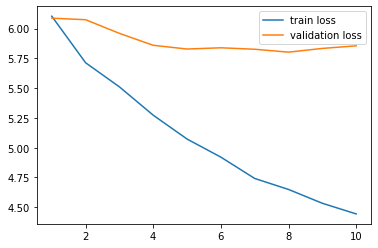

In [73]:
n = range(1,11)
plt.plot(n,e1)
plt.plot(n,e2)
plt.legend(['train loss','validation loss'])
plt.savefig('Seq-to-Seqnn.jpg')

In [100]:
outputs = []
target = []
for text_batch, hl_batch, text_len, headline_len in testloader:
    text_batch = torch.transpose(text_batch, 0, 1) 
    hl_batch = torch.transpose(hl_batch, 0, 1)
    text_batch = text_batch[:text_len.max()]
    hl_batch = hl_batch[:headline_len.max()]
    with torch.no_grad():
        a = seq2seq(text_batch, text_len, hl_batch, teacher_forcing_ratio=0)
        a = a.argmax(2)
    for i in range(a.shape[1]):
        outputs.append(' '.join([headline_vocabulary.index2word[j] for j in a[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)]))
        target.append(' '.join([headline_vocabulary.index2word[j] for j in hl_batch[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)])) 

In [107]:
rouge = Rouge()
r1 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs, target)]
r2 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs, target)]
rl = [rouge.get_scores(o, t)[0]["rouge-l"]['r'] for o, t in zip(outputs, target)]

In [108]:
rouge1 = np.array(r1).mean()
rouge2 = np.array(r2).mean()
rougel = np.array(rl).mean()

In [110]:
rouge1,rouge2,rougel

(0.11359736961329989, 0.022366101976527317, 0.11084906067284304)

In [111]:
target[3]

'create a weekly routine alternating cardio and strength training'

In [116]:
filename = open('S2Snn.txt', 'w')  
for value in outputs:  
     filename.write(value+'\n') 

In [118]:
e1 = np.array(e1)
np.save('train loss nn 128.npy', e1)

In [119]:
e2 = np.array(e2)
np.save('val loss nn 128.npy', e2)